In [1]:
from utils_int import *
from defines_int import *

import numpy as np
import pandas as pd

from collections import Counter

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, StratifiedKFold
import re

import pathlib


from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


# import lime
import lime
import lime.lime_tabular

#pickle
import pickle

#import shap
import shap

In [2]:
# data from variable guide
data_varaible_cat = {}
with open("data_varaible_cat.pkl", "rb") as f:
    data_varaible_cat = pickle.load(f)

len(data_varaible_cat)

911

In [3]:
data = pd.read_pickle(orginal_data_path+'Optima_Data_Report_Cases_9584_filled_pickle')

In [4]:
data.shape

(9584, 1593)

In [5]:
len(attributes_considered)

210

In [6]:
attributes_considered += george_labels_one_years
attributes_considered += george_labels_three_years
attributes_considered = list(set(attributes_considered))
len(attributes_considered)

242

In [7]:
all_dementia = [['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', [1, 2, 3, 4]],
           ['DIAGNOSIS 334-351: DEMENTIA   CLOUDED', [1]],
           ['DIAGNOSIS 334-351: CLOUDED   DEMENTIA', [1]],
           ['DIAGNOSIS 334-351: SEVERITY OF DEMENTIA', [1, 2, 3, 4]],
           ["OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT", [1, 2, 3]],
           ["OPTIMA DIAGNOSES V 2010: MIXED DEMENTIA", [1]],
           ["GENERAL INFORMATION: SPET SCORE", [6]],
           ["GENERAL INFORMATION: DSM-IIIR", [1]],
           ["GENERAL INFORMATION: CLINICAL DIAGNOSIS 1", [1]],
           ["CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA", [1, 2, 3, 4]]]

In [8]:
no_dementia = [['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', [0]],
           ['DIAGNOSIS 334-351: SEVERITY OF DEMENTIA', [0]],
           ["OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT", [0]],
           ["GENERAL INFORMATION: DSM-IIIR", [0]],
           ["GENERAL INFORMATION: CLINICAL DIAGNOSIS 1", [0]]]

In [9]:
dementia = [['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', [1, 2, 3, 4]]]
#            ['DIAGNOSIS 334-351: SEVERITY OF DEMENTIA', [1, 2, 3, 4]]]

In [10]:
dem = set()
for i, j in dementia:
    dem |= extract_values(data, i, j)[0]

2552 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA


In [11]:
all_dem = set()
for i, j in all_dementia:
    all_dem |= extract_values(data, i, j)[0]

2552 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA
10 DIAGNOSIS 334-351: DEMENTIA   CLOUDED
2 DIAGNOSIS 334-351: CLOUDED   DEMENTIA
814 DIAGNOSIS 334-351: SEVERITY OF DEMENTIA
951 OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT
172 OPTIMA DIAGNOSES V 2010: MIXED DEMENTIA
0 GENERAL INFORMATION: SPET SCORE
1 GENERAL INFORMATION: DSM-IIIR
876 GENERAL INFORMATION: CLINICAL DIAGNOSIS 1
2552 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA


In [12]:
no_dem = set()
for i, j in no_dementia:
    no_dem |= extract_values(data, i, j)[0]

2084 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA
985 DIAGNOSIS 334-351: SEVERITY OF DEMENTIA
2185 OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT
1 GENERAL INFORMATION: DSM-IIIR
965 GENERAL INFORMATION: CLINICAL DIAGNOSIS 1


In [13]:
len(dem), len(no_dem), len(all_dem)

(2552, 3647, 3420)

In [14]:
data_dem = data.loc[dem]

In [15]:
data_dem['dementia_range'] = data['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA']

In [16]:
data_dem['dementia_range'].unique()

array([3., 1., 2., 4.])

In [17]:
data_dem.loc[data_dem['dementia_range']==2, 'dementia_range'] = 1
data_dem.loc[data_dem['dementia_range']>1, 'dementia_range'] = 2

In [18]:
data_dem['dementia_range'].unique()

array([2., 1.])

In [19]:
len(no_dem)

3647

In [20]:
no_dem -= all_dem

In [21]:
len(no_dem)

3259

In [22]:
dem_patients = set(data.loc[all_dem].GLOBAL_PATIENT_DB_ID.unique())

In [23]:
no_dem_patients = set(data.loc[no_dem].GLOBAL_PATIENT_DB_ID.unique())

In [24]:
no_dem_patients -= dem_patients

In [25]:
Counter(data_dem['dementia_range'])

Counter({2.0: 1095, 1.0: 1457})

In [26]:
data_no_dem = data.loc[no_dem]
data_no_dem = data_no_dem[data_no_dem['GLOBAL_PATIENT_DB_ID'].isin(no_dem_patients)].sample(1500)
data_no_dem['dementia_range'] = 0

In [27]:
prepared_dataset = pd.concat([data_dem, data_no_dem])[attributes_considered]

In [28]:
for i, j in zip(prepared_dataset, prepared_dataset.dtypes):
    if not (j == "float64" or j == "int64"):
        print(i)
        prepared_dataset[i] = pd.to_numeric(prepared_dataset[i], errors='coerce')

DIAGNOSIS 334-351: SEVERITY OF DEPRESSION
COGNITIVE EXAM 120-161: (147) RECOGNISES PICTURES
COGNITIVE EXAM 162-187: ACTUAL DURATION OF INTERVIEW
DIAGNOSIS 334-351: ANXIETY/PHOBIC
PRESENT STATE 13-46: (018) LIVING ARRANGEMENTS
COGNITIVE EXAM 120-161: (160) SUBTRACTING SEVENS
GENDER
DIAGNOSIS 334-351: DEPRESSIVE ILLNESS


In [29]:
prepared_dataset.shape

(4052, 242)

In [30]:
# drop irrelavent columns
prepared_dataset = prepared_dataset.drop(columns=score_columns)
prepared_dataset = prepared_dataset.replace([-1], [np.nan])
prepared_dataset = drop_missing_columns(prepared_dataset, 0.80)

Before dataset.shape (4052, 235)
After dataset.shape (4052, 127)


In [31]:
currupt_categorical_columns = ['COGNITIVE EXAM 120-161: (158) REGISTERS OBJECTS', 'COGNITIVE EXAM 120-161: (137) IDENTIFIES OBJECTS',]
confused_categorical_columns = ['COGNITIVE EXAM 162-187: (174) MIME - BRUSHING TEETH']                               
categorical_columns = [col for col in prepared_dataset.columns if col in data_varaible_cat.keys()]
categorical_columns_final = list(set(categorical_columns)-set(currupt_categorical_columns)-set(confused_categorical_columns))
drop_columns = ['DIAGNOSIS 334-351: DEPRESSIVE ILLNESS_0.0',
               ]

In [32]:
for column in categorical_columns_final:
    def replace_numerical_category(column, x):
        if x in data_varaible_cat[column]:
            x = data_varaible_cat[column][x]
        else:
            x = np.nan
        return x
    prepared_dataset[column]=prepared_dataset[column].apply(lambda x : replace_numerical_category(column, x))

In [33]:
prepared_dataset[categorical_columns_final] = prepared_dataset[categorical_columns_final].replace([np.nan], ['Unknown'])

In [34]:
def find_mixed_type_list(l):
    for i in range(0,len(l)-1):
        if type(l[i])!=type(l[i+1]):
            return True
    return False
        
list_corrupted_columns = []        
for col in categorical_columns:
    if find_mixed_type_list(prepared_dataset[col].unique().tolist()):
        list_corrupted_columns.append(col)
        print (col,': ',prepared_dataset[col].unique().tolist())

print(len(list_corrupted_columns))

0


In [35]:
for col in list_corrupted_columns:
    print (prepared_dataset.groupby(col)[col].count())

In [36]:
# replace notasked and doesnot know values
# prepared_dataset[categorical_columns] = prepared_dataset[categorical_columns].replace([8, 9], [np.nan, np.nan])

In [37]:
prepared_dataset.shape

(4052, 127)

In [38]:
# drop missing values
prepared_dataset_exp = drop_missing_columns(prepared_dataset, 0.80)
prepared_dataset_exp.shape

Before dataset.shape (4052, 127)
After dataset.shape (4052, 127)


(4052, 127)

In [39]:
# if drop score columns
# prepared_dataset = prepared_dataset[prepared_dataset['CAMDEX SCORES: MINI MENTAL SCORE']>=0]

In [40]:
prepared_dataset.shape

(4052, 127)

In [41]:
# feature transforamtion - one-hot encoding

prepared_dataset_exp = prepared_dataset

new_prepared_data = prepared_dataset_exp.drop(categorical_columns_final, axis=1)
for i in categorical_columns_final:
    x = pd.get_dummies(prepared_dataset_exp[i]).add_prefix(i+'::')
    new_prepared_data = pd.concat([new_prepared_data, x], axis=1)
    
new_prepared_data['dementia_range'] = prepared_dataset_exp['dementia_range']

prepared_dataset_exp = new_prepared_data

In [42]:
prepared_dataset_exp.shape

(4052, 515)

In [43]:
prepared_dataset_exp = prepared_dataset_exp.drop(columns=[col for col in prepared_dataset_exp.columns if '::Unknown' in col])
prepared_dataset_exp.shape

(4052, 396)

In [44]:
prepared_dataset_exp = prepared_dataset_exp.dropna()
prepared_dataset_exp.shape

(3388, 396)

In [45]:
# training data
X_full, y_full = prepared_dataset_exp.drop(columns=['dementia_range']), prepared_dataset_exp['dementia_range']

In [46]:

# impute missing values
'''knn_estimator = KNeighborsRegressor(n_neighbors=15)
imputer = IterativeImputer(random_state=0, estimator=knn_estimator)
X_full_imput = imputer.fit_transform(X_full)
y_full_imput = y_full.values'''

'knn_estimator = KNeighborsRegressor(n_neighbors=15)\nimputer = IterativeImputer(random_state=0, estimator=knn_estimator)\nX_full_imput = imputer.fit_transform(X_full)\ny_full_imput = y_full.values'

In [47]:
X_full_imput, y_full_imput = X_full.values, y_full.values

# model training
def change_feature_names(feature_name):
    p1 = '\w.*\d.*-\d.*:\s\(\d.*\w\)\s'
    p2 = '\w.*:\s'
    feature_name = re.sub(p1, '', feature_name)
    #feature_name = re.sub(p2, '', feature_name)
    for key, value in score_dict.items():
        if feature_name in key:
            feature_name = feature_name+'{}'.format(value)
    return feature_name


rf_estimator = RandomForestClassifier(max_depth=5, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=123)
important_features = set()
important_features_size = 50
for i, (train, test) in enumerate(cv.split(X_full_imput, y_full_imput)):
    rf_estimator.fit(X_full_imput[train], y_full_imput[train])
    y_predicted = rf_estimator.predict(X_full_imput[test])
    print (classification_report(y_full_imput[test], y_predicted))
    
    # print important features
    # model important feature
    fea_importance = rf_estimator.feature_importances_
    indices = np.argsort(fea_importance)[::-1]
    for f in range(important_features_size):
        # print("%d. feature: %s (%f)" % (f + 1, X_full.columns.values[indices[f]], fea_importance[indices[f]]))
        important_features.add(X_full.columns.values[indices[f]])
    #lime interpretability 
    """explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_full_imput[train]), 
                                                       feature_names=[change_feature_names(fea) for fea in X_full.columns.values], 
                                                       class_names=rf_estimator.classes_, discretize_continuous=True, random_state=123)
    exp = explainer.explain_instance(X_full_imput[test][5], rf_estimator.predict_proba, num_features=20)
    exp.show_in_notebook(show_table=True, show_all=False)"""
    #print (exp.as_list())
    #fig = exp.as_pyplot_figure()
    #plt.show()
    
    # shap interpretability
    
#important feature list
print ('important_features: ', list(important_features))

              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94       416
         1.0       0.82      0.85      0.83       410
         2.0       0.87      0.65      0.75       191

    accuracy                           0.86      1017
   macro avg       0.86      0.82      0.84      1017
weighted avg       0.86      0.86      0.86      1017

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       416
         1.0       0.82      0.83      0.83       410
         2.0       0.83      0.65      0.73       191

    accuracy                           0.86      1017
   macro avg       0.85      0.82      0.83      1017
weighted avg       0.86      0.86      0.86      1017

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95       416
         1.0       0.82      0.87      0.85       410
         2.0       0.86      0.66      0.75       191

    accuracy        

In [48]:
prepared_dataset_exp_full = prepared_dataset_exp

#Taking important features
prepared_dataset_exp = prepared_dataset_exp[list(important_features)+['dementia_range']]

X_train, X_test, y_train, y_test = train_test_split(prepared_dataset_exp.drop(columns=['dementia_range']).values, prepared_dataset_exp['dementia_range'].values, test_size=0.3, random_state=42, stratify=prepared_dataset_exp['dementia_range'])

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       416
         1.0       0.76      0.84      0.80       410
         2.0       0.79      0.63      0.70       191

    accuracy                           0.82      1017
   macro avg       0.82      0.79      0.80      1017
weighted avg       0.83      0.82      0.82      1017



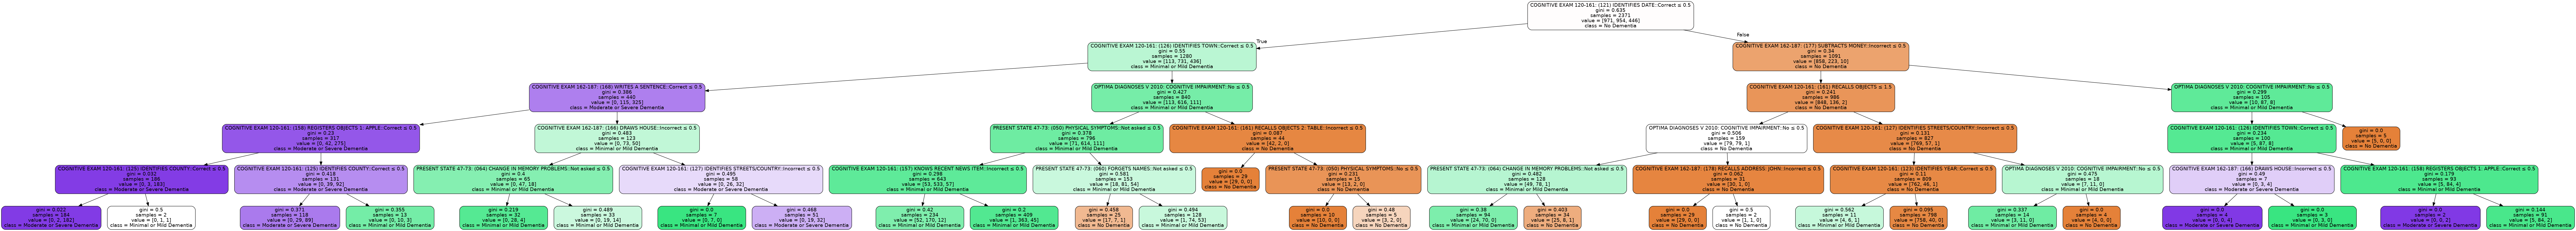

In [51]:
import graphviz
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus, joblib
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

feature_names = prepared_dataset_exp.drop(columns=['dementia_range']).columns

clf = tree.DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train, y_train) 
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print (classification_report(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names, 
               class_names=['No Dementia', 'Minimal or Mild Dementia', 'Moderate or Severe Dementia'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [50]:
def change_feature_names(feature_name):
    p1 = '\w.*\d.*-\d.*:\s\(\d.*\w\)\s'
    p2 = '\w.*:\s'
    feature_name = re.sub(p1, '', feature_name)
    # feature_name = re.sub(p2, '', feature_name)
    for key, value in score_dict.items():
        if feature_name in key:
            feature_name = feature_name+'{}'.format(value)
    return feature_name
    


bool_feature_names_DT = prepared_dataset_exp.select_dtypes(include='uint8').columns
feature_names_DT = [change_feature_names(i) for i in feature_names]
bool_feature_names_DT = [change_feature_names(i) for i in  bool_feature_names_DT] # Important 0: NO and 1: YES
bool_feature_names_true_DT = [i for i in bool_feature_names_DT if '::' in i] #('IDENTIFIES' in i or 'RECALL' in i) and '_1.0' in i ]
bool_feature_names_false_DT = [i for i in bool_feature_names_DT if '::' in i] #('IDENTIFIES' in i or 'RECALL' in i) and '_0.0' in i ]
feature_names_for_split_DT = [i for i in feature_names_DT if ' SCORE' in i] 


viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='class',
               feature_names=feature_names_DT,
               bool_feature_names_true=bool_feature_names_true_DT,
               bool_feature_names_false=bool_feature_names_false_DT,
               feature_names_for_split=feature_names_for_split_DT,
               class_names=['No Dementia', 'Minimal or Mild Dementia', 'Moderate or Severe Dementia'],
               fancy=False, label_fontsize=40, ticks_fontsize=2)

viz.save('model_4DT.svg')
drawing = svg2rlg("./model_4DT.svg".format(i))
renderPDF.drawToFile(drawing, "./model_4DT.pdf".format(i))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
